# Initial Model

Done by: Chamath Wijerathne, Nada Rahali, Tanjuma Haque

In [200]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import Ridge
from typing import Tuple
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import math
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.compose import TransformedTargetRegressor
import time

In [201]:
# loading the dataset from raw data folder
def load_and_prepare(file1, file2):
    # loading raw CSVs
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)

    # merging row-wise
    df = pd.concat([df1, df2], axis=0, ignore_index=True)

    # removing  unwanted index columns (like "Unnamed: 0")
    df = df.loc[:, ~df.columns.str.contains("^Unnamed")]
    df1 = df1.loc[:, ~df1.columns.str.contains("^Unnamed")]
    df2 = df2.loc[:, ~df2.columns.str.contains("^Unnamed")]

    # splitting spectra (X) vs traits (Y)
    wl_cols = [c for c in df.columns if str(c).isdigit()]
    trait_cols = [c for c in df.columns if c not in wl_cols]


    X = df[wl_cols].copy()
    Y = df[trait_cols].copy()

    wls = np.array(list(map(int, X.columns)))

    trait_cols_df1 = [c for c in df1.columns if c not in wl_cols]
    trait_cols_df2 = [c for c in df2.columns if c not in wl_cols]
    Y_df1 = df1[trait_cols_df1].copy()
    Y_df2 = df2[trait_cols_df2].copy()

    print(f"Trait columns in df1: {Y_df1.columns.tolist()}")
    print(f"Trait columns in df2: {Y_df2.columns.tolist()}")

    print(f"Dataset loaded: {df.shape[0]} samples, {X.shape[1]} spectra, {Y.shape[1]} traits")
    return X, Y, df, df1, df2, wls, wl_cols, trait_cols

X, Y, df, df1, df2, wls, wl_cols, trait_cols = load_and_prepare(
    "../data/raw/data_part_1.csv", 
    "../data/raw/data_part_2.csv"
)

Trait columns in df1: ['Anthocyanin content (μg/cm²)', 'Boron content (mg/cm²)', 'C content (mg/cm²)', 'Ca content (mg/cm²)', 'Carotenoid content (μg/cm²)', 'Cellulose (mg/cm²)', 'Chl content (μg/cm²)', 'Copper content (mg/cm²)', 'EWT (mg/cm²)', 'Fiber (mg/cm²)', 'LAI (m²/m²)', 'LMA (g/m²)', 'Lignin (mg/cm²)', 'Magnesium content (mg/cm²)', 'Manganese content (mg/cm²)', 'N content (mg/cm²)', 'NSC (mg/cm²)', 'Phosphorus content (mg/cm²)', 'Potassium content (mg/cm²)', 'Sulfur content (mg/cm²)']
Trait columns in df2: ['Anthocyanin content (μg/cm²)', 'Anthocyanin concentration (mg/g)', 'Boron content (mg/cm²)', 'Boron concentration (mg/g)', 'C content (mg/cm²)', 'C concentration (mg/g)', 'Ca content (mg/cm²)', 'Ca concentration (mg/g)', 'Carotenoid content (μg/cm²)', 'Carotenoid concentration (mg/g)', 'Cellulose (mg/cm²)', 'Cellulose (mg/g)', 'Chl content (μg/cm²)', 'Chlorophyll concentration (mg/g)', 'Copper content (mg/cm²)', 'Copper concentration (mg/g)', 'EWT (mg/cm²)', 'Fiber (mg/cm²)

In [202]:
# quick look at the data
df.head()

,Anthocyanin content (μg/cm²),Boron content (mg/cm²),C content (mg/cm²),Ca content (mg/cm²),Carotenoid content (μg/cm²),Cellulose (mg/cm²),Chl content (μg/cm²),Copper content (mg/cm²),EWT (mg/cm²),Fiber (mg/cm²),...,Copper concentration (mg/g),Fiber (mg/g),Lignin (mg/g),Magnesium concentration (mg/g),Manganese concentration (mg/g),N concentration (mg/g),NSC (mg/g),P concentration (mg/g),Potassium concentration (mg/g),Sulfur concentration (mg/g)
0,NaN,NaN,NaN,0.091526,NaN,NaN,34.047382,NaN,10.889923,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,0.038488,NaN,NaN,23.320021,NaN,10.270048,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,0.026577,NaN,NaN,27.098073,NaN,11.423791,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,0.013190,NaN,NaN,27.638014,NaN,13.132381,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,0.082163,NaN,NaN,23.159727,NaN,11.625371,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Adjustment of the initial pretreatment plan

### Feedback: Drop duplicate columns in a different measurement unit and we will be focusing on the common traits between the two datasets

Upon visual inspection from above, traits are measured in two ways (per-area vs per-mass) and both datasets have the per-mass while one dataset has extra, duplicate trait columns but for per-area. Example of unit differing duplicate columns:
- Chlorophyll content (μg/cm²) vs Chlorophyll concentration (mg/g)


In [203]:
# Examing  traits: per-area vs per-mass
print("All traits:")
for col in Y.columns:
    print(f"  {col}")

# separating per-area and per-mass traits
per_area = [col for col in Y.columns if '(mg/cm²)' in col or '(μg/cm²)' in col or '(g/m²)' in col or '(m²/m²)' in col]
per_mass = [col for col in Y.columns if '(mg/g)' in col or 'concentration' in col]

# summary for traits verification 
print(f"Per-area: {len(per_area)} traits")
print(f"Per-mass: {len(per_mass)} traits")

All traits:
  Anthocyanin content (μg/cm²)
  Boron content (mg/cm²)
  C content (mg/cm²)
  Ca content (mg/cm²)
  Carotenoid content (μg/cm²)
  Cellulose (mg/cm²)
  Chl content (μg/cm²)
  Copper content (mg/cm²)
  EWT (mg/cm²)
  Fiber (mg/cm²)
  LAI (m²/m²)
  LMA (g/m²)
  Lignin (mg/cm²)
  Magnesium content (mg/cm²)
  Manganese content (mg/cm²)
  N content (mg/cm²)
  NSC (mg/cm²)
  Phosphorus content (mg/cm²)
  Potassium content (mg/cm²)
  Sulfur content (mg/cm²)
  Anthocyanin concentration (mg/g)
  Boron concentration (mg/g)
  C concentration (mg/g)
  Ca concentration (mg/g)
  Carotenoid concentration (mg/g)
  Cellulose (mg/g)
  Chlorophyll concentration (mg/g)
  Copper concentration (mg/g)
  Fiber (mg/g)
  Lignin (mg/g)
  Magnesium concentration (mg/g)
  Manganese concentration (mg/g)
  N concentration (mg/g)
  NSC (mg/g)
  P concentration (mg/g)
  Potassium concentration (mg/g)
  Sulfur concentration (mg/g)
Per-area: 20 traits
Per-mass: 17 traits


In [204]:
# Dropping the duplicates per-mass traits
Y_cleaned = Y.drop(columns=per_mass)
print(f"After dropping per-mass traits, {Y_cleaned.shape[1]} traits remain.")
print("Traits kept:")
for col in Y_cleaned.columns:
    print(" -", col)

After dropping per-mass traits, 20 traits remain.
Traits kept:
 - Anthocyanin content (μg/cm²)
 - Boron content (mg/cm²)
 - C content (mg/cm²)
 - Ca content (mg/cm²)
 - Carotenoid content (μg/cm²)
 - Cellulose (mg/cm²)
 - Chl content (μg/cm²)
 - Copper content (mg/cm²)
 - EWT (mg/cm²)
 - Fiber (mg/cm²)
 - LAI (m²/m²)
 - LMA (g/m²)
 - Lignin (mg/cm²)
 - Magnesium content (mg/cm²)
 - Manganese content (mg/cm²)
 - N content (mg/cm²)
 - NSC (mg/cm²)
 - Phosphorus content (mg/cm²)
 - Potassium content (mg/cm²)
 - Sulfur content (mg/cm²)


## Feedback incorporation

### Standardizing the data occurs after splitting into cal/val/test.

In order to avoid data leakage, the dataset is first split into calibration, validation, and test sets. After the split, standardization is applied using only the calibration set, and then those values are used to transform the validation and test sets. This way, the test and validation data remains completely unseen during calibration.


In [205]:
# 1st: Shuffle the dataset
# 2nd: Split the dataset into calibration (60%) and validation (20%) and testing (20%) sets
train_df, val_df, test_df = np.split(
    df.sample(frac=1, random_state=42),
    [int(.6*len(df)), int(.8*len(df))]
)

# Separate X and Y for each set
X_train, Y_train = train_df[wl_cols], train_df[trait_cols]
X_val,   Y_val   = val_df[wl_cols], val_df[trait_cols]
X_test,  Y_test  = test_df[wl_cols], test_df[trait_cols]
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

e:\MSc\ADAML\GroupProject\Spectral-Soft-Sensor-Project_old\.venv\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Training set: 7977 samples
Validation set: 2659 samples
Testing set: 2659 samples


In [206]:
# Standardize the data 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Use the same scaler to transform validation and test sets
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)


print("Training set shape:", X_train_scaled.shape)
print("Validation set shape:", X_val_scaled.shape)
print("Testing set shape:", X_test_scaled.shape)

Training set shape: (7977, 1721)
Validation set shape: (2659, 1721)
Testing set shape: (2659, 1721)


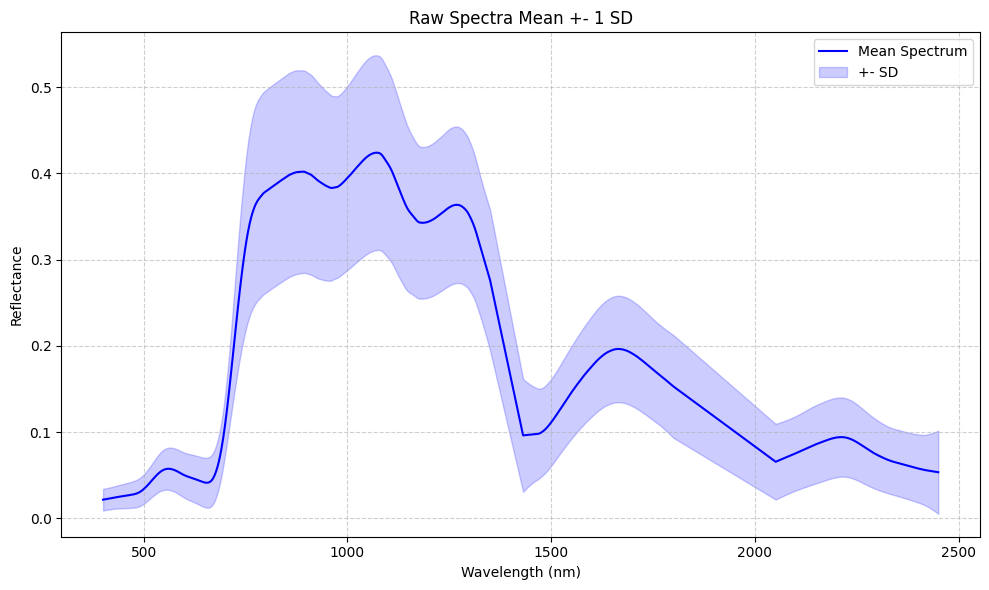

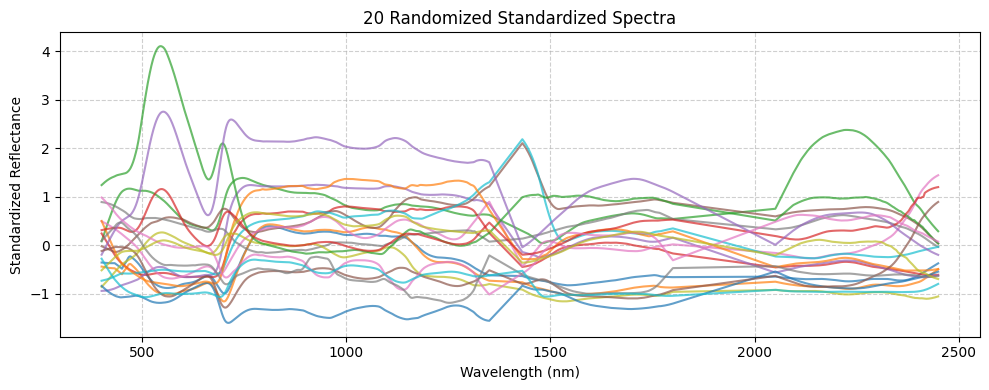

In [207]:
# Plotting raw (unscaled) spectra mean +- 1 SD 
mu_raw = X.mean(axis=0).values
sd_raw = X.std(axis=0).values

plt.figure(figsize=(10, 6))
plt.plot(wls, mu_raw, label='Mean Spectrum', color='blue')
plt.fill_between(wls, mu_raw - sd_raw, mu_raw + sd_raw, 
                 color='blue', alpha=0.2, label='+- SD')
plt.title('Raw Spectra Mean +- 1 SD')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# plotting 20 randomized standardized spectra (post-scaling)
np.random.seed(42)
random_indices = np.random.choice(X_train_scaled.shape[0], size=20, replace=False)

plt.figure(figsize=(10,4))
for idx in random_indices:
    plt.plot(wls, X_train_scaled[idx, :], alpha=0.7)
plt.title("20 Randomized Standardized Spectra")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Standardized Reflectance")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Dimensionality reduction of spectra (X)

This is done following this step:  
- **Dimensionality Reduction:** Apply PCA only on spectra (X)  

In [208]:
# Applying PCA only on the standardized training spectra
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca   = pca.transform(X_val_scaled)
X_test_pca  = pca.transform(X_test_scaled)

print("Training PCA shape:", X_train_pca.shape)
print("Validation PCA shape:", X_val_pca.shape)
print("Testing PCA shape:", X_test_pca.shape)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("Explained variance by each component:\n", explained_variance)
print("Cumulative explained variance:\n", cumulative_variance)

Training PCA shape: (7977, 1721)
Validation PCA shape: (2659, 1721)
Testing PCA shape: (2659, 1721)
Explained variance by each component:
 [5.67043209e-01 3.15618441e-01 5.42424766e-02 ... 2.40139310e-21
 2.38694836e-21 2.31235593e-21]
Cumulative explained variance:
 [0.56704321 0.88266165 0.93690413 ... 1.         1.         1.        ]


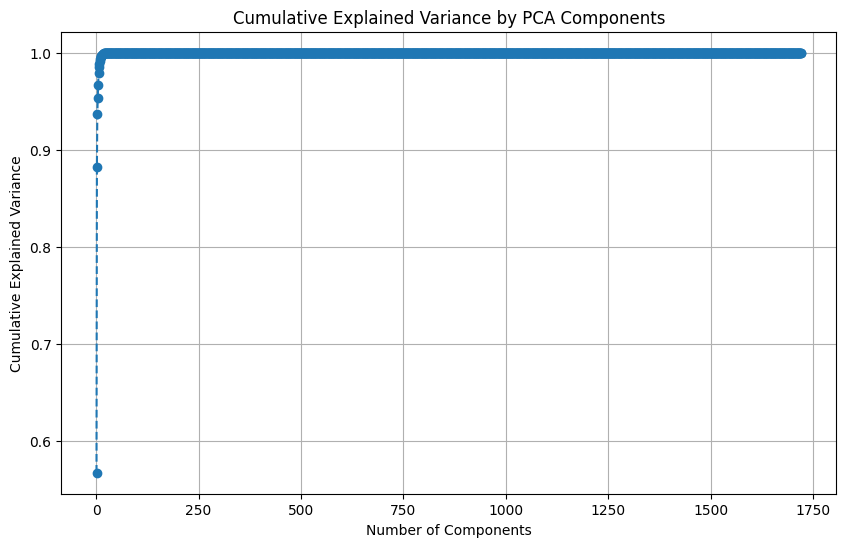

In [209]:
# Plotting the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()

In [210]:
# Retaining just enough components to explain 95% of the total variance in the spectral data (X)
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of PCs explaining 95% variance: {n_components}")

# Re-running PCA with the selected number of components (fit only on training set)
pca_final = PCA(n_components=n_components)
X_train_reduced = pca_final.fit_transform(X_train_scaled)
X_val_reduced   = pca_final.transform(X_val_scaled)
X_test_reduced  = pca_final.transform(X_test_scaled)

print("Reduced training shape:", X_train_reduced.shape)
print("Reduced validation shape:", X_val_reduced.shape)
print("Reduced testing shape:", X_test_reduced.shape)

Number of PCs explaining 95% variance: 4
Reduced training shape: (7977, 4)
Reduced validation shape: (2659, 4)
Reduced testing shape: (2659, 4)


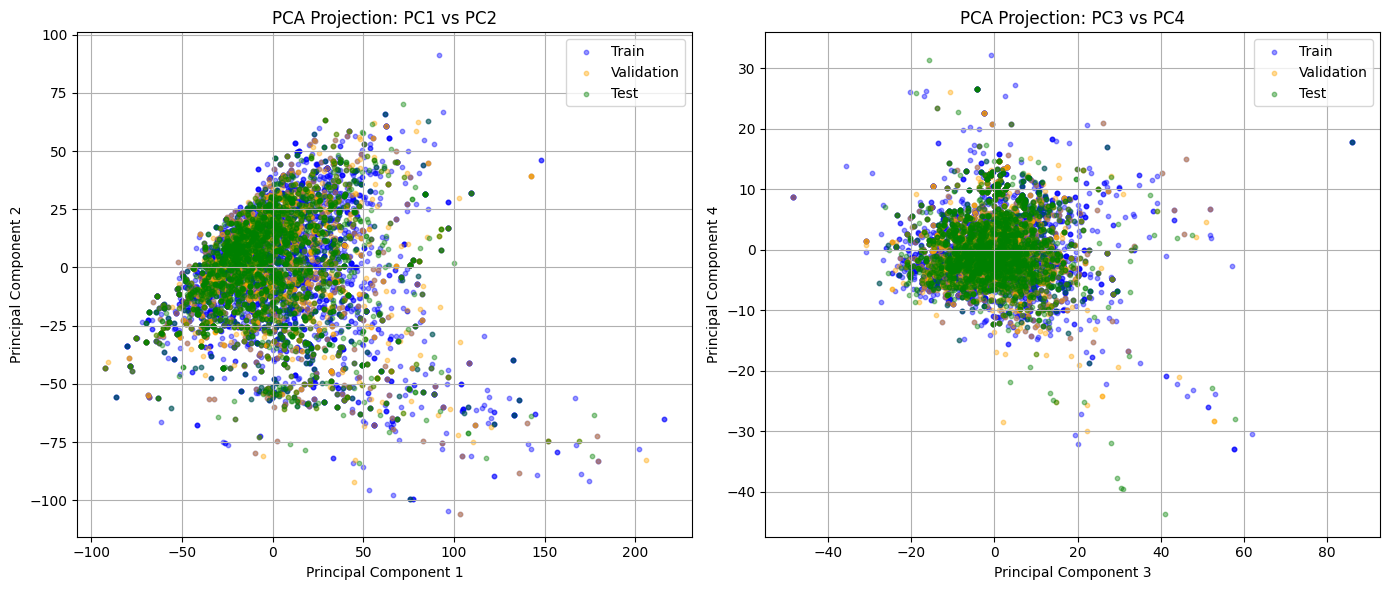

In [211]:
# Plotting PC1 vs PC2 and PC3 vs PC4 from the reduced spectra
plt.figure(figsize=(14, 6))

# PC1 vs PC2 
plt.subplot(1, 2, 1)
plt.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], 
            alpha=0.4, s=10, c='blue', label="Train")
plt.scatter(X_val_reduced[:, 0], X_val_reduced[:, 1], 
            alpha=0.4, s=10, c='orange', label="Validation")
plt.scatter(X_test_reduced[:, 0], X_test_reduced[:, 1], 
            alpha=0.4, s=10, c='green', label="Test")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection: PC1 vs PC2")
plt.legend()
plt.grid(True)

# PC3 vs PC4
if X_train_reduced.shape[1] >= 4:
    plt.subplot(1, 2, 2)
    plt.scatter(X_train_reduced[:, 2], X_train_reduced[:, 3], 
                alpha=0.4, s=10, c='blue', label="Train")
    plt.scatter(X_val_reduced[:, 2], X_val_reduced[:, 3], 
                alpha=0.4, s=10, c='orange', label="Validation")
    plt.scatter(X_test_reduced[:, 2], X_test_reduced[:, 3], 
                alpha=0.4, s=10, c='green', label="Test")
    plt.xlabel("Principal Component 3")
    plt.ylabel("Principal Component 4")
    plt.title("PCA Projection: PC3 vs PC4")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [212]:
# checking the first few rows of the reduced data
print("First 5 rows of reduced spectra:\n", X_train_reduced[:5])

First 5 rows of reduced spectra:
 [[ -1.70985164  27.70234465  -0.07476941   3.13320172]
 [ -8.64355903  16.51494446   9.51824791   6.25275382]
 [ 12.26636996  13.81573213   1.19582457  14.75198286]
 [-41.29948681 -19.98027708   5.53926611   2.73139419]
 [-11.25002735  -0.17092848   0.15809381   9.07501853]]


In [213]:
# checking missing values in both the spectra (X) and the traits (Y) so they could be dropped before modeling
print("Missing values in spectra:", X.isna().sum().sum())
print("Missing values in traits:", Y_cleaned.isna().sum().sum()) #not all trait values were measured

Missing values in spectra: 0
Missing values in traits: 175528


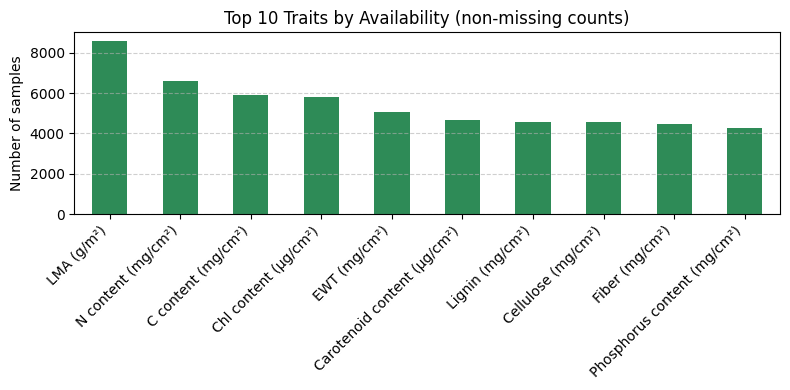

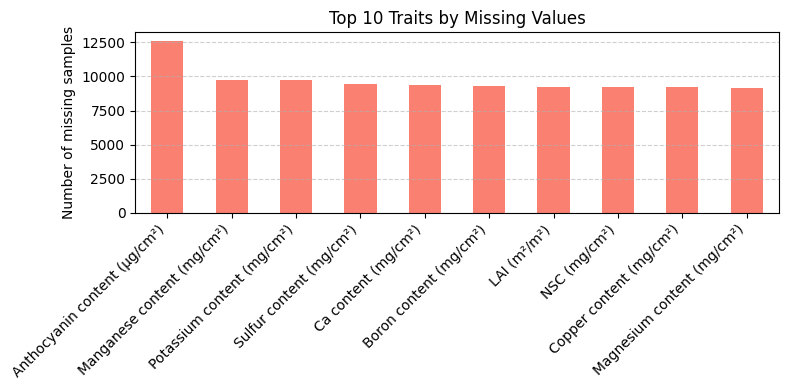

In [214]:
# trait availability (non-missing counts) and missingness
avail = Y_cleaned.notna().sum().sort_values(ascending=False)
miss  = Y_cleaned.isna().sum().sort_values(ascending=False)

# plotting top 10 available traits
plt.figure(figsize=(8,4))
avail.head(10).plot(kind='bar', color='seagreen')
plt.title("Top 10 Traits by Availability (non-missing counts)")
plt.ylabel("Number of samples")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# plotting top 10 traits with most missing values
plt.figure(figsize=(8,4))
miss.head(10).plot(kind='bar', color='salmon')
plt.title("Top 10 Traits by Missing Values")
plt.ylabel("Number of missing samples")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Model Calibration

In [215]:
#doing another check of common traits between the two datasets (df1 and df2)
traits_df1 = [c for c in df1.columns if c not in wl_cols]
traits_df2 = [c for c in df2.columns if c not in wl_cols]

# common traits by name
common_traits_all = sorted(list(set(traits_df1).intersection(set(traits_df2))))

# drop per-mass (mgg) variants and generic "concentration" to keep area-based traits
def is_per_mass(name: str) -> bool:
    nm = name.lower()
    return ('(mg/g)' in nm) or ('concentration' in nm)

commontraits = [t for t in common_traits_all if not is_per_mass(t)]

print(f"Common traits found (after dropping per-mass/concentration): {len(commontraits)}")
for t in commontraits:
    print(" -", t)



Common traits found (after dropping per-mass/concentration): 20
 - Anthocyanin content (μg/cm²)
 - Boron content (mg/cm²)
 - C content (mg/cm²)
 - Ca content (mg/cm²)
 - Carotenoid content (μg/cm²)
 - Cellulose (mg/cm²)
 - Chl content (μg/cm²)
 - Copper content (mg/cm²)
 - EWT (mg/cm²)
 - Fiber (mg/cm²)
 - LAI (m²/m²)
 - LMA (g/m²)
 - Lignin (mg/cm²)
 - Magnesium content (mg/cm²)
 - Manganese content (mg/cm²)
 - N content (mg/cm²)
 - NSC (mg/cm²)
 - Phosphorus content (mg/cm²)
 - Potassium content (mg/cm²)
 - Sulfur content (mg/cm²)


In [216]:
def get_split_for_trait(trait: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
   
    m_train = ~Y_train[trait].isna()
    m_val   = ~Y_val[trait].isna()
    m_test  = ~Y_test[trait].isna()

    Xtrain = X_train.loc[m_train].to_numpy()
    Xval   = X_val.loc[m_val].to_numpy()
    Xtest  = X_test.loc[m_test].to_numpy()

    ytrain = Y_train.loc[m_train, trait].to_numpy(dtype=float)
    yval   = Y_val.loc[m_val, trait].to_numpy(dtype=float)
    ytest  = Y_test.loc[m_test, trait].to_numpy(dtype=float)

    return Xtrain, ytrain, Xval, yval, Xtest, ytest

In [217]:
#def q2_score(y_true, y_pred):
#    ss_res = np.sum((y_true - y_pred) ** 2)
#    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
#    return 1 - ss_res / ss_tot

#def metrics(y_true, y_pred):
#    q2 = q2_score(y_true, y_pred)
#    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
#    mae  = mean_absolute_error(y_true, y_pred)
#    return {"Q2": q2, "RMSE": rmse, "MAE": mae}

def q2_score(y_true, y_pred):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / ss_tot

def metrics(y_true, y_pred):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    return {"Q2": q2_score(y_true, y_pred), "RMSE": rmse, "MAE": mae}

In [218]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = "neg_mean_squared_error"  

# 1) PCR = StandardScaler -> PCA -> LinearRegression
#pcr = Pipeline([
#    ("scaler", StandardScaler(with_mean=True, with_std=True)),
#    ("pca", PCA(svd_solver="auto", random_state=42)),
#    ("linreg", LinearRegression())
#])

#pcr_grid = {
#    "pca__n_components": [10, 20, 30, 50, 75]
#}

pcr = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("pca", PCA(svd_solver="auto", random_state=42)),
    ("ttr", TransformedTargetRegressor(
        regressor=LinearRegression(),
        transformer=StandardScaler(with_mean=True, with_std=True)
    ))
])
pcr_grid = {
    "pca__n_components": [10, 20, 30, 50, 75]
}

# 2) PLS = StandardScaler -> PLSRegression 
#pls = Pipeline([
#    ("scaler", StandardScaler(with_mean=True, with_std=True)),
#    ("pls", PLSRegression(scale=False))
#])

#pls_grid = {
#    "pls__n_components": [5, 10, 15, 20, 25]
#}

pls = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("ttr", TransformedTargetRegressor(
        regressor=PLSRegression(scale=False),
        transformer=StandardScaler(with_mean=True, with_std=True)
    ))
])
pls_grid = {
    "ttr__regressor__n_components": [5, 10, 15, 20, 25]
}

# 3) MLR baseline = StandardScaler -> LinearRegression
#mlr = Pipeline([
#    ("scaler", StandardScaler(with_mean=True, with_std=True)),
#    ("mlr", LinearRegression())
#])

#mlr_grid = {}  # no hyperparameters to tune

mlr = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("ttr", TransformedTargetRegressor(
        regressor=Ridge(),
        transformer=StandardScaler(with_mean=True, with_std=True)
    ))
])

mlr_grid = {
    "ttr__regressor__alpha": [0.1, 1.0, 10.0, 100.0]
}

models_dict = {
    "PCR": (pcr, pcr_grid),
    "PLS": (pls, pls_grid),
    "MLR": (mlr, mlr_grid),
}

In [219]:
class KernelPLS(BaseEstimator, RegressorMixin):
    """
    Simplified kPLS using RBF kernel + sklearn PLSRegression.
    """
    def __init__(self, n_components=10, gamma=0.01):
        self.n_components = n_components
        self.gamma = gamma

    def fit(self, X, y):
        self.X_fit_ = X
        K = rbf_kernel(X, X, gamma=self.gamma)
        y = np.asarray(y)
        if y.ndim == 1:
            y = y.reshape(-1, 1)
        self.pls_ = PLSRegression(n_components=self.n_components)
        self.pls_.fit(K, y)
        return self

    def predict(self, X):
        K_test = rbf_kernel(X, self.X_fit_, gamma=self.gamma)
        return self.pls_.predict(K_test)

# adding kernel PLS to the pipeline and param grid
#kpls = Pipeline([
#    ("scaler", StandardScaler(with_mean=True, with_std=True)),
#    ("kpls", KernelPLS())
#])
#kpls_grid = {
#    "kpls__n_components": [5, 10, 15],
#    "kpls__gamma": [0.001, 0.005, 0.01, 0.02]
#}


kpls = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("ttr", TransformedTargetRegressor(
        regressor=KernelPLS(),
        transformer=StandardScaler(with_mean=True, with_std=True)
    ))
])

kpls_grid = {
    "ttr__regressor__n_components": [5, 10, 15],
    "ttr__regressor__gamma": [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
}

# updating the models_dict dictionary to include kPLS
models_dict = {
    "PCR": (pcr, pcr_grid),
    "PLS": (pls, pls_grid),
    "MLR": (mlr, mlr_grid),
    "kPLS": (kpls, kpls_grid)  
}

In [220]:
results = []     # one row per (trait, model)
best_models = {}  # to store the best model per (trait, model) for later

for trait in commontraits:
    Xtrain, ytrain, Xval, yval, Xte, ytest = get_split_for_trait(trait)
    # skipping if too few samples
    if len(ytrain) < 150:  
        print(f"skipping {trait} (too few calibration samples: {len(ytrain)})")
        continue

    print(f"\n🔧 trait: {trait}  |  train={len(ytrain)}  val={len(yval)}  test={len(ytest)}")

    for name, (pipe, grid) in models_dict.items():
        start_time = time.time()
        g = GridSearchCV(
            estimator=pipe,
            param_grid=grid,
            scoring=scoring,
            cv=cv,
            n_jobs=-1,
            refit=True,        
            verbose=0
        )
        g.fit(Xtrain, ytrain) # fitting on training set only
        elapsed_time = time.time() - start_time

        # validation performance
        yval_pred = g.predict(Xval) 
        m_val = metrics(yval, yval_pred)

        # test performance
        ytest_pred = g.predict(Xte)
        m_test = metrics(ytest, ytest_pred)

        results.append({
            "Trait": trait,
            "Model": name,
            "Train_sample": len(ytrain), 
            "Val_sample": len(yval), 
            "Test_sample": len(ytest),
            "BestParams": g.best_params_,
            "Val_Q2": m_val["Q2"],   "Val_RMSE": m_val["RMSE"], "Val_MAE": m_val["MAE"],
            "Test_Q2": m_test["Q2"], "Test_RMSE": m_test["RMSE"], "Test_MAE": m_test["MAE"],
            "Computation_time_sec": round(elapsed_time, 2)
        })

        best_models[(trait, name)] = g

results_df = pd.DataFrame(results).sort_values(["Trait", "Val_RMSE"]).reset_index(drop=True)
display(results_df.head(20))

results_df.to_csv("../reports/model_selection_results.csv", index=False)
print(" Saved: ../reports/model_selection_results.csv")


🔧 trait: Anthocyanin content (μg/cm²)  |  train=437  val=124  test=137

🔧 trait: Boron content (mg/cm²)  |  train=2427  val=795  test=807

🔧 trait: C content (mg/cm²)  |  train=3555  val=1168  test=1166

🔧 trait: Ca content (mg/cm²)  |  train=2373  val=773  test=774

🔧 trait: Carotenoid content (μg/cm²)  |  train=2822  val=918  test=902

🔧 trait: Cellulose (mg/cm²)  |  train=2744  val=896  test=901

🔧 trait: Chl content (μg/cm²)  |  train=3498  val=1146  test=1139

🔧 trait: Copper content (mg/cm²)  |  train=2459  val=809  test=815

🔧 trait: EWT (mg/cm²)  |  train=3061  val=993  test=1030

🔧 trait: Fiber (mg/cm²)  |  train=2707  val=879  test=887

🔧 trait: LAI (m²/m²)  |  train=2433  val=793  test=816

🔧 trait: LMA (g/m²)  |  train=5182  val=1688  test=1710

🔧 trait: Lignin (mg/cm²)  |  train=2784  val=893  test=912

🔧 trait: Magnesium content (mg/cm²)  |  train=2479  val=829  test=830

🔧 trait: Manganese content (mg/cm²)  |  train=2141  val=692  test=691

🔧 trait: N content (mg/cm²)  

,Trait,Model,Train_sample,Val_sample,Test_sample,BestParams,Val_Q2,Val_RMSE,Val_MAE,Test_Q2,Test_RMSE,Test_MAE,Computation_time_sec
0,Anthocyanin content (μg/cm²),kPLS,437,124,137,"{'ttr__regressor__gamma': 0.0001, 'ttr__regres...",0.390239,0.304601,0.218284,0.539599,0.284773,0.201950,0.82
1,Anthocyanin content (μg/cm²),MLR,437,124,137,{'ttr__regressor__alpha': 0.1},0.357750,0.312611,0.232027,0.581750,0.271424,0.191800,0.27
2,Anthocyanin content (μg/cm²),PCR,437,124,137,{'pca__n_components': 30},0.333429,0.318475,0.233530,0.519573,0.290900,0.211697,3.73
3,Anthocyanin content (μg/cm²),PLS,437,124,137,{'ttr__regressor__n_components': 15},0.315083,0.322828,0.240759,0.514583,0.292407,0.210845,0.64
4,Boron content (mg/cm²),kPLS,2427,795,807,"{'ttr__regressor__gamma': 0.05, 'ttr__regresso...",0.912727,0.000075,0.000025,0.847941,0.000104,0.000027,15.04
5,Boron content (mg/cm²),MLR,2427,795,807,{'ttr__regressor__alpha': 0.1},0.491600,0.000180,0.000127,0.560577,0.000176,0.000120,1.88
6,Boron content (mg/cm²),PCR,2427,795,807,{'pca__n_components': 75},0.489701,0.000180,0.000128,0.557983,0.000176,0.000124,2.20
7,Boron content (mg/cm²),PLS,2427,795,807,{'ttr__regressor__n_components': 25},0.425982,0.000191,0.000134,0.490314,0.000190,0.000130,3.24
8,C content (mg/cm²),kPLS,3555,1168,1166,"{'ttr__regressor__gamma': 0.05, 'ttr__regresso...",0.928188,1.355316,0.458283,0.907763,1.459103,0.505454,32.04
9,C content (mg/cm²),MLR,3555,1168,1166,{'ttr__regressor__alpha': 0.1},0.708327,2.731429,1.919190,0.730249,2.495251,1.819216,2.55


 Saved: ../reports/model_selection_results.csv


In [221]:
# pick best model per trait by Val_RMSE
best_by_trait = (
    results_df
    .sort_values(["Trait", "Val_RMSE"])
    .groupby("Trait", as_index=False)
    .first()
)

display(best_by_trait[["Trait", "Model", "BestParams", "Val_Q2", "Val_RMSE", "Test_Q2", "Test_RMSE"]])

best_by_trait.to_csv("../reports/best_models_per_trait.csv", index=False)
print("Saved: ../reports/best_models_per_trait.csv")

,Trait,Model,BestParams,Val_Q2,Val_RMSE,Test_Q2,Test_RMSE
0,Anthocyanin content (μg/cm²),kPLS,"{'ttr__regressor__gamma': 0.0001, 'ttr__regres...",0.390239,0.304601,0.539599,0.284773
1,Boron content (mg/cm²),kPLS,"{'ttr__regressor__gamma': 0.05, 'ttr__regresso...",0.912727,0.000075,0.847941,0.000104
2,C content (mg/cm²),kPLS,"{'ttr__regressor__gamma': 0.05, 'ttr__regresso...",0.928188,1.355316,0.907763,1.459103
3,Ca content (mg/cm²),kPLS,"{'ttr__regressor__gamma': 0.05, 'ttr__regresso...",0.905769,0.029254,0.877871,0.036249
4,Carotenoid content (μg/cm²),kPLS,"{'ttr__regressor__gamma': 0.05, 'ttr__regresso...",0.869498,1.061661,0.829463,1.126963
5,Cellulose (mg/cm²),kPLS,"{'ttr__regressor__gamma': 0.05, 'ttr__regresso...",0.899975,0.675046,0.883582,0.665831
6,Chl content (μg/cm²),kPLS,"{'ttr__regressor__gamma': 0.05, 'ttr__regresso...",0.826757,5.794686,0.835246,5.459793
7,Copper content (mg/cm²),kPLS,"{'ttr__regressor__gamma': 0.05, 'ttr__regresso...",0.883613,0.000011,0.880685,0.000011
8,EWT (mg/cm²),kPLS,"{'ttr__regressor__gamma': 0.05, 'ttr__regresso...",0.914471,3.013028,0.882047,3.505349
9,Fiber (mg/cm²),kPLS,"{'ttr__regressor__gamma': 0.05, 'ttr__regresso...",0.903139,1.591517,0.878724,1.706947


Saved: ../reports/best_models_per_trait.csv


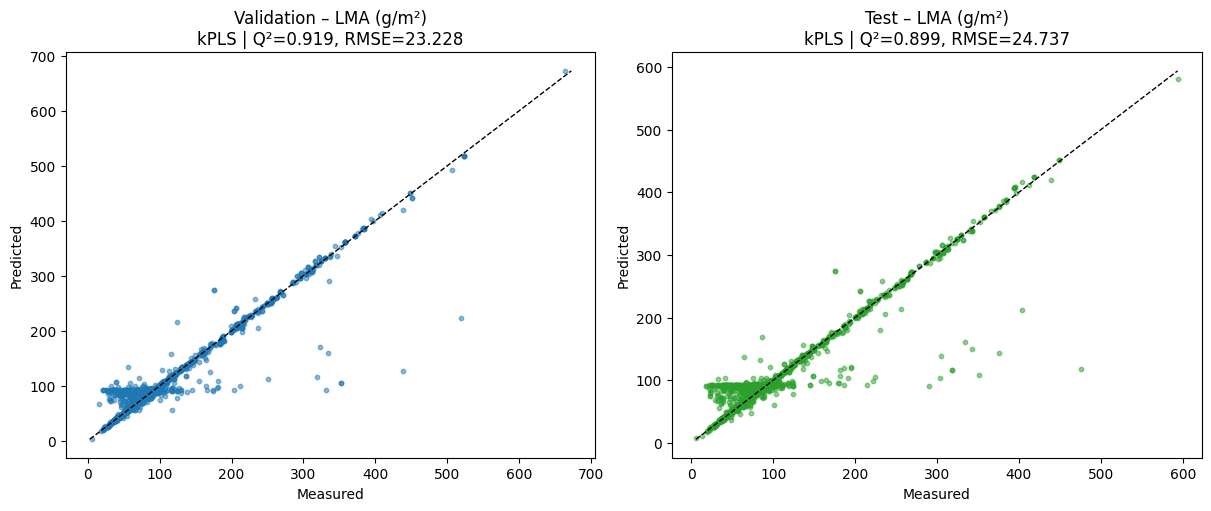

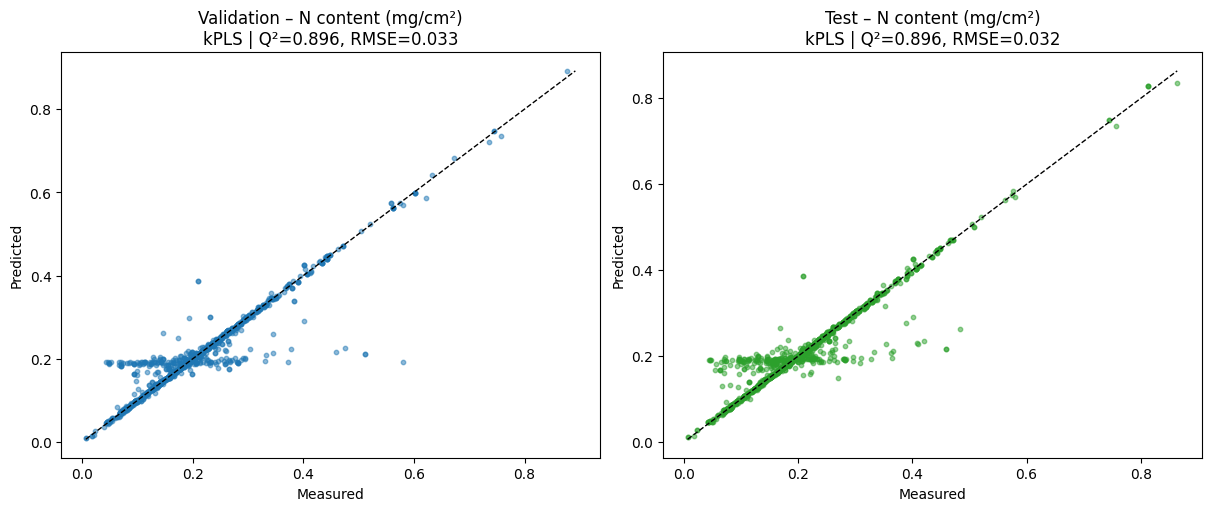

In [222]:
def plot_pred_meas(trait: str, model_name: str = None):
    """
    to show predicted vs measured for the chosen trait for both validation and test sets.
    If model_name is None, we go with the best model by validation RMSE.
    """
    # choosing the model
    if model_name is None:
        row = (results_df[results_df["Trait"] == trait]
               .sort_values("Val_RMSE")
               .iloc[0])
        model_name = row["Model"]

    g = best_models.get((trait, model_name), None)
    if g is None:
        raise ValueError(f"No trained model stored for ({trait}, {model_name}).")

    # get splits
    Xtrain, ytrain, Xval, yval, Xte, ytest = get_split_for_trait(trait)
    yval_pred = g.predict(Xval)
    ytest_pred = g.predict(Xte)

    # metrics
    mv = metrics(yval, yval_pred)
    mt = metrics(ytest, ytest_pred)

    # plotting
    fig, ax = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

    # validation
    ax[0].scatter(yval, yval_pred, s=10, alpha=0.5)
    lims = [min(yval.min(), yval_pred.min()), max(yval.max(), yval_pred.max())]
    ax[0].plot(lims, lims, 'k--', lw=1)
    ax[0].set_title(f"Validation – {trait}\n{model_name} | Q²={mv['Q2']:.3f}, RMSE={mv['RMSE']:.3f}")
    ax[0].set_xlabel("Measured"); ax[0].set_ylabel("Predicted")

    # test
    ax[1].scatter(ytest, ytest_pred, s=10, alpha=0.5, color="tab:green")
    lims = [min(ytest.min(), ytest_pred.min()), max(ytest.max(), ytest_pred.max())]
    ax[1].plot(lims, lims, 'k--', lw=1)
    ax[1].set_title(f"Test – {trait}\n{model_name} | Q²={mt['Q2']:.3f}, RMSE={mt['RMSE']:.3f}")
    ax[1].set_xlabel("Measured"); ax[1].set_ylabel("Predicted")

    plt.show()

# an example: plot for two frequently measured traits
plot_pred_meas("LMA (g/m²)")
plot_pred_meas("N content (mg/cm²)")

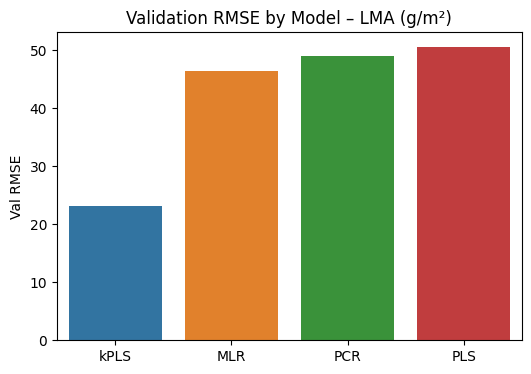

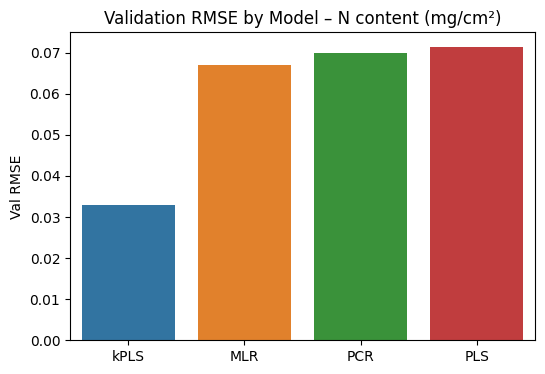

In [223]:
def bar_compare_trait(trait: str):
    sub = results_df[results_df["Trait"] == trait].copy()
    if sub.empty:
        print(f"No results for trait: {trait}")
        return
    plt.figure(figsize=(6,4))
    sns.barplot(data=sub.sort_values("Val_RMSE"), x="Model", y="Val_RMSE", hue="Model", dodge=False, legend=False)
    plt.title(f"Validation RMSE by Model – {trait}")
    plt.ylabel("Val RMSE"); plt.xlabel("")
    plt.show()

bar_compare_trait("LMA (g/m²)")
bar_compare_trait("N content (mg/cm²)")

In [224]:
def sanity(trait):
    _, _, Xv, yv, _, yt = get_split_for_trait(trait)
    print(trait)
    print("  Val n:", len(yv), " Val mean:", yv.mean(), " Val std:", yv.std())
    print("  Test n:", len(yt), " Test mean:", yt.mean(), " Test std:", yt.std())

sanity("LMA (g/m²)")
sanity("N content (mg/cm²)")

LMA (g/m²)
  Val n: 1688  Val mean: 108.54167385515048  Val std: 81.4142633601525
  Test n: 1710  Test mean: 106.18003950701929  Test std: 77.81383008766421
N content (mg/cm²)
  Val n: 1310  Val mean: 0.20695838906946565  Val std: 0.10213019647225423
  Test n: 1321  Test mean: 0.20650636708024223  Test std: 0.0983917294655325


In [225]:
# function for plotting residul plots per trait and model
def plot_residuals(trait: str, model_name: str = None):
    if model_name is None:
        row = (results_df[results_df["Trait"] == trait]
               .sort_values("Val_RMSE")
               .iloc[0])
        model_name = row["Model"]

    g = best_models.get((trait, model_name), None)
    if g is None:
        raise ValueError(f"No trained model stored for ({trait}, {model_name}).")

    Xtrain, ytrain, Xval, yval, Xtest, ytest = get_split_for_trait(trait)
    yval_pred = g.predict(Xval)
    residuals = yval - yval_pred.flatten()

    plt.figure(figsize=(6, 4))
    plt.scatter(yval_pred, residuals, alpha=0.6)
    plt.axhline(0, color="red", linestyle="--", lw=1)
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot – {trait} ({model_name})")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

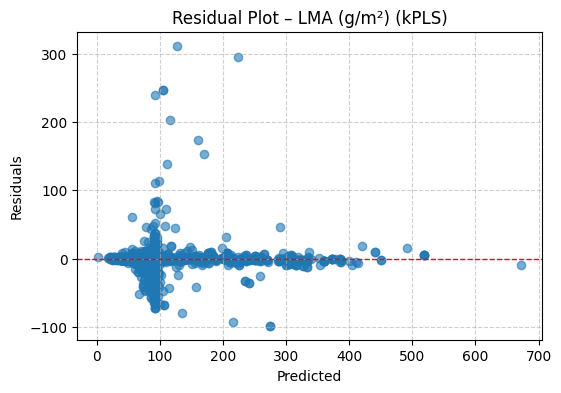

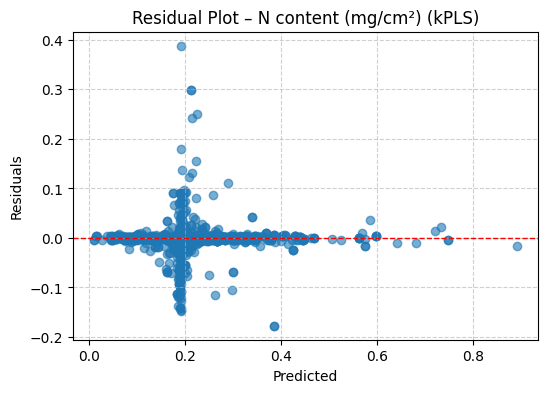

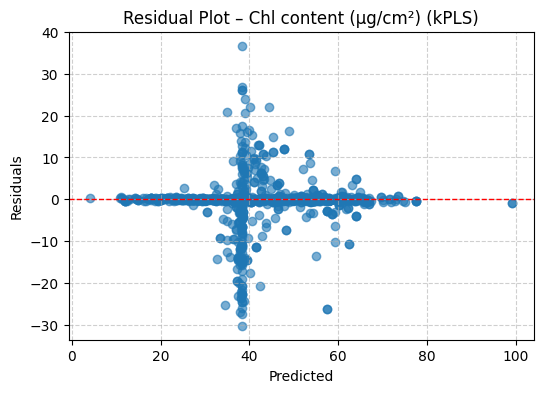

In [226]:
#inspecting
important_traits = ["LMA (g/m²)", "N content (mg/cm²)", "Chl content (μg/cm²)"]

for t in important_traits:
    model_name = best_by_trait.loc[best_by_trait["Trait"] == t, "Model"].values[0]
    plot_residuals(t, model_name)